# Data import and pre-process

In [1]:
import os

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["OMP_NUM_THREADS"]="1"

In [1]:
# imports


import sklearn as sk
import numpy as np
import pandas as pd





from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import RFE

from sklearn.metrics import classification_report

from treeinterpreter import treeinterpreter as ti

from numpy import array


from sklearn.metrics import *

import time


#from multiprocessing import Pool  # somehow work in jupyter lab
from multiprocess import Pool # if in jupyter notebook
import tqdm

import random

from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import *




from sklearn.metrics import auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score as aps


import pickle


from fs_utils import *


In [3]:
sk.__version__  # => 1.0 

'1.1.1'

In [4]:
def get_metrics(predies):
    accs = []
    pres = []
    auc = []
    
    flat_pred = []
    flat_y = []
    
    for e in predies:
        for i in range(len(e[0])):
            flat_pred.append(e[1][i])
            flat_y.append(e[0][i])        
    
    for e in predies:
        auc.append(roc_auc_score(e[0], e[1]))
    
    for e in predies:
        pres.append(precision_score(e[0], e[1],zero_division= 0))
    
    for e in predies:
        accs.append(accuracy_score(e[0], e[1]))
        
        
    print("AUC: ", np.mean(auc), " | ", np.std(auc))
    print("accuracy: ", np.mean(accs), " | ", np.std(accs))
    print("precision: ", np.mean(pres), " | ", np.std(pres))
    print("classi report:" , classification_report(flat_pred, flat_y))
    tn, fp, fn, tp  = confusion_matrix(flat_y, flat_pred).ravel()
    print()
    print("tn fp fn tp")
    print(tn, fp, fn, tp)

# Feature set search

In [2]:
dida = []
kg = []

In [3]:
folder = "data/"


di_f = folder + "OLIDA_training_set_annotated.txt"
kg_f = folder + "1KGP_training_set_olida_annotated.txt" 


kg = pd.read_csv(kg_f, sep="\t")
di = pd.read_csv(di_f, sep="\t")


In [4]:
di["y"] = 1
kg["y"] = 0

In [5]:
di
kg

,Combination_ID,CADD1,CADD2,CADD3,CADD4,BiolDist,ISPP_AR_A,ISPP_AR_B,ISPP_AD_A,ISPP_AD_B,ISPP_XL_A,HIPred_A,HIPred_B,dn_ds_A,BPO_sim,KG_dist,y
0,set_1_neg_1,1.788,-3.000,0.458,-3.0,18.889,0.104,0.019,0.000,0.022,-0.5,0.167,0.219,0.687,0.012,1.500,0
1,set_1_neg_2,0.055,-3.000,0.658,-3.0,10.066,0.017,0.723,0.006,0.026,-0.5,0.783,0.476,0.129,0.058,1.000,0
2,set_1_neg_3,0.293,-3.000,-0.177,-3.0,35.781,0.014,0.078,0.013,0.000,-0.5,0.198,0.146,0.184,NaN,1.000,0
3,set_1_neg_4,0.498,-3.000,0.456,-3.0,27.500,0.048,0.022,0.639,0.013,-0.5,0.233,0.343,0.638,0.010,1.500,0
4,set_1_neg_5,2.473,2.473,1.122,-3.0,19.444,0.639,0.599,0.027,0.000,-0.5,0.698,0.589,0.369,0.096,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150495,set_500_neg_297,3.161,-3.000,1.560,-3.0,26.905,0.006,0.018,0.653,0.000,-0.5,0.471,0.450,0.443,0.037,1.000,0
150496,set_500_neg_298,-0.150,-3.000,0.643,-3.0,29.423,0.006,0.155,0.009,0.090,-0.5,NaN,0.542,0.074,0.299,1.000,0
150497,set_500_neg_299,0.138,-3.000,2.251,-3.0,NaN,0.031,0.000,0.000,0.000,-0.5,0.173,0.132,0.861,0.020,1.333,0
150498,set_500_neg_300,3.109,-3.000,0.647,-3.0,NaN,0.025,0.000,0.006,0.013,-0.5,0.540,0.324,0.343,0.021,1.500,0


In [14]:
# make balanced sample
kgs = kg.sample(n=len(di))

In [15]:
df = pd.concat((di,kgs))

In [17]:
# impute missing values as median

for c in df.columns[1:-1]:
    df[c] = pd.to_numeric(df[c], errors = 'coerce')
imputevals = df.median(numeric_only=True)
df = df.fillna(imputevals)



In [18]:
nfeats = len(di.columns)-2  # all - y - comb_id

In [23]:
# Check for feature correlations

cor_mat = di.corr().abs()
upedie = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))

upedie

/var/folders/65/zyvlz10x27115c6qxk95plmc0000gn/T/ipykernel_24675/3183213111.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upedie = cor_mat.where(np.triu(np.ones(cor_mat.shape), k=1).astype(np.bool))


,CADD1,CADD2,CADD3,CADD4,ISPP_AR_A,ISPP_AD_A,ISPP_XL_A,dn_ds_A,y
CADD1,NaN,0.242051,0.078616,0.032427,0.040498,0.125011,0.031752,0.015886,NaN
CADD2,NaN,NaN,0.082566,0.263321,0.220740,0.141102,0.287076,0.105269,NaN
CADD3,NaN,NaN,NaN,0.347846,0.055709,0.099600,0.057985,0.110386,NaN
CADD4,NaN,NaN,NaN,NaN,0.116386,0.061238,0.005681,0.084265,NaN
ISPP_AR_A,NaN,NaN,NaN,NaN,NaN,0.328756,0.149805,0.235467,NaN
ISPP_AD_A,NaN,NaN,NaN,NaN,NaN,NaN,0.094534,0.246241,NaN
ISPP_XL_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082702,NaN
dn_ds_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# see if any have more than .4 correlation
to_drop = [column for column in upedie.columns if any(upedie[column] > 0.4)]
to_drop

[]

In [25]:
get_cols(df, [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]).columns

Index(['Combination_ID', 'CADD1', 'CADD3', 'ISPP_AD_A', 'BP_similarity',
       'KG_dist', 'Coexpression', 'Coexpression', 'y'],
      dtype='object')

wrapper search

In [ ]:
#import sys
#f = open("fseval.txt", "w")  # writing output to file if long job
#sys.stdout = f


def gen_5(df, sf):
    li = []
    for _ in range(10):
        f = random_move(sf)
        if str(f) in f_mem:
            li.append((f_mem[str(f)], f))
        else:
            perf = eval_f(df, f)
            f_mem[str(f)] = perf
            li.append((perf,f))
    return li






for _ in tqdm.tqdm(range(10000)):
    sff = [1 for _ in range(len(df.columns)-2)]
    max_int = int("".join(str(x) for x in sff), 2)
    
    sf = n_to_f(random.randrange(1,max_int), nfeats)
    
    ctr = 0
    
    f_mem = {}
    
    print("Starting SF: ", str(sf))
    
    l = gen_5(df, sf)    
    best = (0,0)
    while len(l) != 0 and ctr < 100:
        ctr +=1
        to_eval = []
        for e in l:
            to_eval += gen_5(df, e[1])
        l+=to_eval    

        l.sort()
    
        l = l[-5:]
        if best[0] < l[-1][0]:
            ctr = 0
        best = l[-1]
        print("\t", l[-1])
    print(l[-1]   )
        




In [ ]:
!notify "feval done" # push notification when done

# Feature set evaluation

In [20]:
dida = []
kg = []

In [21]:

folder = "data/"




di_f = folder + "OLIDA_annotated_set.txt"
kg_f = folder + "1KGP_unstratified_OLIDA_maffilter_annotated_set.txt" 
#kg_f = folder + "1kgp_missingvaluesstratified_annotated_set_new_features.txt" 


kg = pd.read_csv(kg_f, sep="\t")
di = pd.read_csv(di_f, sep="\t")


/Users/nversbra/miniconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:


p_f = folder + "unstratified_olida_training_data_pairs.txt"




p = pd.read_csv(p_f, sep="\t")


gps = {}
for e in array(p):
    gps[e[0]] = e[1] +"/"+e[2]

gpps = []

gps_all = []
for e in kg.Combination_ID:
    gpps.append(gps[e])
    gps_all.append(gps[e])
    
kg["gp"]=gpps
gpps = []

for e in di.Combination_ID:
    gpps.append(gps[e]) 
    gps_all.append(gps[e])    
di["gp"]=gpps    

di_gps = list(set(gpps))

In [23]:
di["y"] = 1
kg["y"] = 0

In [24]:
di
kg

,Combination_ID,CADD1,CADD2,CADD3,CADD4,Biol_Dist,ISPP_AR_A,ISPP_AR_B,ISPP_AD_A,ISPP_AD_B,...,HIPred_B,dn_ds_A,dn_ds_B,BP_similarity,MF_similarity,Mentha_dist,KG_dist,Coexpression,gp,y
0,set_1_neg_1,0.090,-3.000,3.204,-3.0,25.513,0.041,0.009,0.022,0.0,...,0.38,0.164,0.325,0.0,0.017,26.024,1.0,-1.209,PEAR1/COL11A2,0
1,set_1_neg_2,1.655,0.719,3.894,-3.0,30.77,0.019,0.054,0.741,0.006,...,0.216,0.096,0.522,0.031,0.087,36.863,1.0,-0.513,KLHL23/CMPK1,0
2,set_1_neg_3,1.275,-3.000,-0.247,-3.0,None,0.019,0.013,0.0,0.0,...,0.112,0.466,0.537,0.0,0.943,66.284,1.0,None,LOXL2/OR4D5,0
3,set_1_neg_4,2.399,-3.000,0.342,-3.0,18.889,0.743,0.042,0.006,0.011,...,0.578,0.416,0.388,0.0,1.0,40.462,1.0,-1.083,DBT/ASIC4,0
4,set_1_neg_5,4.269,-3.000,3.753,-3.0,12.346,0.006,0.035,0.032,0.04,...,0.197,0.401,0.644,0.029,0.504,45.236,1.0,-0.492,NLRC5/ISX,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150995,set_500_neg_297,0.067,-3.000,-0.124,-3.0,16.768,0.022,0.006,0.0,0.015,...,0.532,0.485,0.763,0.0,0.932,22.252,1.0,None,HADHA/UGT2B4,0
150996,set_500_neg_298,-0.286,-3.000,0.322,-3.0,18.333,0.164,0.091,0.023,0.169,...,0.158,0.545,0.201,0.138,0.037,39.592,1.0,None,AACS/GOLM1,0
150997,set_500_neg_299,-0.194,-3.000,-0.408,-3.0,None,0.006,0.686,0.006,0.0,...,0.146,0.2,0.469,0.067,0.0,54.236,1.0,-1.547,PROC/ST13,0
150998,set_500_neg_300,0.316,-3.000,-0.087,-3.0,16.16,0.044,0.026,0.0,0.033,...,0.595,0.192,0.351,0.003,0.983,89.035,1.0,None,GRIK1/ALG9,0


In [25]:
nfeats = len(di.columns)-3  # also GP

In [37]:

for c in kg.columns[1:-2]:
    kg[c] = pd.to_numeric(kg[c], errors = 'coerce')
    
for c in di.columns[1:-2]:
    di[c] = pd.to_numeric(di[c], errors = 'coerce')

    

In [12]:
dfm = pd.concat((di,kg))

In [38]:
imputevalsdi = di.median(numeric_only=True)
imputevalskg = kg.median(numeric_only=True)

impmed = imputevalsdi/2+ imputevalskg/2



In [ ]:
#import sys 
#f = open("bfeval.txt", "w")  # writing to file if long job
#sys.stdout = f


# List of feature sets to evaluate
fol = [[1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0],[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]]

def train_logo(logo):
    
        rf_models = []
        testsets = []
    
        for trainset in trainers:
            
            trainset.reset_index(drop=True, inplace=True) 
    
    
            train = trainset[trainset.gp != logo]
            test = trainset[trainset.gp == logo]
            
            to_rem = len(test)
            
            df_1KGP = train[train.y ==0] 
            idx = df_1KGP.sample(to_rem)
            test = pd.concat([test, idx])
            train = train.drop(idx.index, axis=0) 
            
            
            testsets.append(test)
            X = (array(train)[:,1:-2].astype(float))
            y = array(train.y)
            
            # train Random Forest
            clf = RandomForestClassifier()
            new_clf = clf.fit(X, y)
        
            # add random forests for each set
            rf_models += [[new_clf]]
            
        y_test_all = []
        predictions = []
        for testset in testsets:
            X_test = (array(testset)[:,1:-2].astype(float))
            y_test = array(testset.y)
            for t in y_test:
                y_test_all.append(t)
            for m in rf_models:
                predictions.append(m[0].predict_proba(X_test))
            sample_preds = [ [] for _ in range(len(y_test))]
            for p in predictions:
                for sp in range(len(p)):
                    sample_preds[sp].append(p[sp][1])
            v_pred = []        
            for p in sample_preds:
                med_pred = np.median(p)
                sup = [1 if x >= .532 else 0 for x in p] # VarCoPP original thresh
                sup = sum(sup)/len(e[0])
                if med_pred >= .532 and sup >= .5:
                    v_pred.append(1)
                else:     
                    v_pred.append(0)
        return y_test_all, v_pred

for fo in tqdm.tqdm(fol):

    trainers = []
    for i in range(1, 501):
        setn = str(i) 
        kgi = kg[kg.Combination_ID.str.match(r'(set_'+setn+'_.*)')==True]   
        tdf = pd.concat([kgi, di])
        tdf = tdf.fillna(impmed)
        tdf = get_cols(tdf, fo)
        trainers.append(tdf)
    
    for i in range(len(trainers)):
        trainers[i] = sk.utils.shuffle(trainers[i]) 
        
        
    

    
    p = Pool(40)    # change to cores available
    predies = list(tqdm.tqdm(p.imap_unordered(train_logo, di_gps[0:2]), total=len(di_gps)))
    p.close()
    
    print("\n")
    print(fo)
    print()
    get_metrics(predies)
    print("-"*30)
    print("\n")

In [17]:
!notify "bfeval done"

# Independent set evaluation

In [39]:

og_tf = folder + "OLIDA_test_set_annotated.txt"
kg_tf = folder + "1KGP_test_set_annotated.txt"  



kgt = pd.read_csv(kg_tf, sep="\t")
ogt = pd.read_csv(og_tf, sep="\t")


In [40]:
for c in ogt.columns[1:]:
    ogt[c] = pd.to_numeric(ogt[c], errors = 'coerce')
#imputevals = ogt.median(numeric_only=True)
ogt = ogt.fillna(impmed)
ogt["y"] = 1
ogt[:5]

,Combination_ID,CADD1,CADD2,CADD3,CADD4,Biol_Dist,ISPP_AR_A,ISPP_AR_B,ISPP_AD_A,ISPP_AD_B,...,HIPred_A,HIPred_B,dn_ds_A,dn_ds_B,BP_similarity,MF_similarity,Mentha_dist,KG_dist,Coexpression,y
0,testpos_1,5.956,-3.000,1.511,-3.0,13.819,0.006,0.588,0.108,0.013,...,0.786,0.170,0.243,0.442,0.002,0.703,27.606,1.0,-0.0910,1
1,testpos_2,2.771,-3.000,2.943,-3.0,17.218,0.240,0.668,0.662,0.006,...,0.414,0.544,0.302,0.148,0.039,0.604,32.009,1.0,0.7535,1
2,testpos_3,8.363,-3.000,2.492,-3.0,1.250,0.060,0.106,0.755,0.016,...,0.698,0.694,0.092,0.234,0.467,0.057,49.928,1.0,-1.7370,1
3,testpos_4,3.472,-3.000,1.534,-3.0,10.710,0.098,0.000,0.688,0.049,...,0.639,0.784,0.173,0.224,0.020,0.038,34.001,1.0,-1.5040,1
4,testpos_5,3.090,1.385,2.227,-3.0,1.250,0.060,0.106,0.755,0.016,...,0.698,0.694,0.092,0.234,0.467,0.057,49.928,1.0,-1.7370,1


In [41]:

for c in kgt.columns[1:]:
    kgt[c] = pd.to_numeric(kgt[c], errors = 'coerce')
#imputevals = kgt.median(numeric_only=True)
kgt = kgt.fillna(impmed)
kgt["y"] = 0
kgt[:5]

,Combination_ID,CADD1,CADD2,CADD3,CADD4,Biol_Dist,ISPP_AR_A,ISPP_AR_B,ISPP_AD_A,ISPP_AD_B,...,HIPred_A,HIPred_B,dn_ds_A,dn_ds_B,BP_similarity,MF_similarity,Mentha_dist,KG_dist,Coexpression,y
0,testneg_1,-0.442,-3.0,1.051,-3.0,10.710,0.064,0.059,0.013,0.0060,...,0.276,0.12300,1.975,0.93300,0.12925,0.495,52.22200,1.333,0.2050,0
1,testneg_2,2.232,-3.0,0.916,-3.0,12.539,0.036,0.006,0.016,0.0000,...,0.554,0.11200,0.206,1.14500,0.00000,0.894,16.94900,1.000,-0.3440,0
2,testneg_3,0.095,-3.0,0.353,-3.0,10.833,0.718,0.013,0.023,0.0000,...,0.599,0.11200,0.271,0.40400,0.00000,0.849,27.89000,1.000,-0.7660,0
3,testneg_4,2.387,-3.0,0.538,-3.0,10.710,0.089,0.050,0.012,0.0145,...,0.372,0.45075,0.200,0.31675,0.04900,0.270,30.97325,1.000,0.7535,0
4,testneg_5,-0.006,-3.0,-0.224,-3.0,21.389,0.025,0.085,0.727,0.0000,...,0.659,0.61800,0.257,0.39300,0.03500,0.342,33.11800,2.000,0.7535,0


In [42]:
valset = pd.concat((kgt,ogt))
valset = sk.utils.shuffle(valset)

In [ ]:

num_trees = 100
max_depth = 10




fos = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]]

#fos = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]]


for fo in fos:
    
    # create sets
    kgt1 = get_cols(valset, fo)
    trainers = []
    for i in range(1, 501):
        setn = str(i) 
        kgi = kg[kg.Combination_ID.str.match(r'(set_'+setn+'_.*)')==True]   
        tdf = pd.concat([kgi, di])
        tdf = tdf.fillna(impmed)
        tdf = get_cols(tdf, fo)
        trainers.append(tdf)

    for i in range(len(trainers)):
        trainers[i] = sk.utils.shuffle(trainers[i]) 
        
    X_1KGP = array(kgt1)[:,1:-2].astype(float)
    y_1kgp = array(kgt1.y)


    # train

    rf_models = []

    for trainset in tqdm.tqdm(trainers):
        trainset.reset_index(drop=True, inplace=True) 
        train = trainset
    
        X = (array(train)[:,1:-2].astype(float))
        y = array(train.y)
        # train Random Forest
        clf = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth)
        new_clf = clf.fit(X, y)
    
        # add random forests for each set
        rf_models += [[new_clf]]
 
    # predict
    predictions = []
    for m in rf_models:
        predictions.append(m[0].predict_proba(X_1KGP))
    sample_preds = [ [] for _ in range(len(X_1KGP))]
    for p in predictions:
        for sp in range(len(p)):
            sample_preds[sp].append(p[sp][1])
    v_pred = []        
    for p in sample_preds:
        med_pred = np.median(p)
        sup = [1 if x >= .532 else 0 for x in p]
        sup = sum(sup)/len(e[0])
        if med_pred >= .532 and sup >= .5:
            v_pred.append(1)
        else:     
            v_pred.append(0)
    print(fo)
    get_metrics([(y_1kgp, v_pred)])
    print()



# Model structure evaluation

In [6]:
dida = []
kg = []

In [7]:
folder = "data/"




di_f = folder + "OLIDA_training_set_annotated.txt"
kg_f = folder + "1KGP_training_set_olida_annotated.txt" 
#kg_f = folder + "1kgp_missingvaluesstratified_annotated_set_new_features.txt" 

kg = pd.read_csv(kg_f, sep="\t")
di = pd.read_csv(di_f, sep="\t")


/Users/nversbra/miniconda3/envs/py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:


p_f = folder + "unstratified_olida_training_data_pairs.txt"




p = pd.read_csv(p_f, sep="\t")


gps = {}
for e in array(p):
    gps[e[0]] = e[1] +"/"+e[2]

gpps = []

gps_all = []
for e in kg.Combination_ID:
    gpps.append(gps[e])
    gps_all.append(gps[e])
    
kg["gp"]=gpps
gpps = []

for e in di.Combination_ID:
    gpps.append(gps[e]) 
    gps_all.append(gps[e])    
di["gp"]=gpps    

di_gps = list(set(gpps))
gp_u = set(gps_all)
all_gps = list(gp_u)


In [9]:
di["y"] = 1
kg["y"] = 0

In [10]:
nfeats = len(di.columns)-3  # also GP

In [11]:

for c in kg.columns[1:-2]:
    kg[c] = pd.to_numeric(kg[c], errors = 'coerce')
    
for c in di.columns[1:-2]:
    di[c] = pd.to_numeric(di[c], errors = 'coerce')

    

In [12]:
dfm = pd.concat((di,kg))

In [13]:
imputevalsdi = di.median(numeric_only=True)
imputevalskg = kg.median(numeric_only=True)

impmed = imputevalsdi/2+ imputevalskg/2

In [14]:
dfm = dfm.fillna(impmed)

In [15]:


og_tf = folder + "OLIDA_test_set_annotated.txt"
kg_tf = folder + "1KGP_test_set_annotated.txt"  



kgt = pd.read_csv(kg_tf, sep="\t")
ogt = pd.read_csv(og_tf, sep="\t")


In [16]:
for c in ogt.columns[1:]:
    ogt[c] = pd.to_numeric(ogt[c], errors = 'coerce')
ogt = ogt.fillna(impmed)
ogt["y"] = 1


In [17]:

for c in kgt.columns[1:]:
    kgt[c] = pd.to_numeric(kgt[c], errors = 'coerce')
imputevals = kgt.median(numeric_only=True)
kgt = kgt.fillna(impmed)
kgt["y"] = 0


In [18]:

ts = pd.concat((ogt,kgt))
ts = sk.utils.shuffle(ts)

fo = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]
#kgt1 = get_cols(ogt, fo)
kgt1 = get_cols(ts, fo)

Ensemble RFs

In [ ]:


f = open("xrf_eval.txt", "w")


num_trees = 100
max_depth = 10
    


#kgs = kg.sample(n=317)
df = pd.concat((di,kg))
df = df.fillna(imputevals)

#for num_forests in tqdm.tqdm(range(1,500, 5)):
num_forests = 500


kgt1 = ts
    
#for num_forests in tqdm.tqdm(range(1,501, 10)):
#for num_forests in range(1,501, 10):    



di = di.fillna(imputevals)

trainers = []
for i in range(1, num_forests+1):
    setn = str(i) 
    kgi = kg[kg.Combination_ID.str.match(r'(set_'+setn+'_.*)')==True]   
    tdf = kgi
    tdf = tdf.fillna(imputevals)
    trainers.append(tdf)
for i in range(len(trainers)):
    trainers[i] = sk.utils.shuffle(trainers[i]) #.sample(frac=1)
    

    
#for num_trees in range(1,501, 10):        
#    print("trees: ", num_trees)
#    f.write("trees: "+ str(num_trees)+ " ")

for num_forests in range(1,501, 10):        
    print("num_forests: ", num_forests)
    #print("trees: ", num_trees)
    f.write("forests: "+ str(num_forests)+ " ")
    
    y_trues = []
    testsets = []
    predsets = []
    k_fold = KFold(5)
    for k, (train_i, test_i) in enumerate(k_fold.split(di)):

        testsets_f = None
        edited = False
        rf_models = []
        for trainset in trainers[:num_forests]:
            trainset.reset_index(drop=True, inplace=True)         
            train = array(di)[train_i]
            test = array(di)[test_i]
    
            to_rem = len(test)
                
            df_1KGP = trainset[trainset.y ==0] 
            idx = df_1KGP.sample(to_rem)
            test = array(idx)# np.concatenate([test, array(idx)])
            
            test_y = test[:,-1]
            for e in test_y:
                y_trues.append(e)
                
            train_k = trainset.drop(idx.index, axis=0) 
            train = np.concatenate([train, array(train_k)])
            
            if not edited:
                testsets_f = test
                edited = True
            else:    
                testsets_f = np.concatenate((testsets_f,test))
        
            
            X = (array(train)[:,1:-2].astype(float))
            y = train[:,-1].astype(int)

            clf = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth)

            new_clf = clf.fit(X, y)
            rf_models += [[new_clf]]
        for trainset in trainers[num_forests:]:
            test = array(di)[test_i]
            to_rem = len(test)
            df_1KGP = trainset[trainset.y ==0] 
            idx = df_1KGP.sample(to_rem)
            test = array(idx)
            test_y = test[:,-1]
            for e in test_y:
                y_trues.append(e)
            testsets_f = np.concatenate((testsets_f,test))                
            
        test = array(di)[test_i]
        testsets_f = np.concatenate((testsets_f,test))
        test_y = test[:,-1]
        for e in test_y:
            y_trues.append(e)
        
        predictions = []
        #print(testsets_f)
        a_test = array(testsets_f)[:,1:-2].astype(float)
        #print(a_test)
        for m in rf_models:
            predictions.append(m[0].predict_proba(a_test))
            
        sample_preds = [ [] for _ in range(len(a_test))]
        for p in predictions:
            for sp in range(len(p)):
                sample_preds[sp].append(p[sp][1])
        v_pred = []        
        for p in sample_preds:
            med_pred = np.median(p)
            v_pred.append(med_pred)
        predsets.append(v_pred)
        testsets.append(testsets_f)

    testsets = [x for l in testsets for x in l]
    pred_all = [x for l in predsets for x in l]

    
    precision, recall, thresholds = precision_recall_curve(y_trues, pred_all)

    auc_precision_recall = auc(recall, precision)
    print(auc_precision_recall)
    print(aps(y_trues, pred_all)) 
    print(roc_auc_score(y_trues, pred_all))
    f.write(str(auc_precision_recall)+" "+ str(aps(y_trues, pred_all))+ " "+ str(roc_auc_score(y_trues, pred_all)) + "\n")





!notify "num forests model structure done"


BRF and RF


In [ ]:

#f = open("brf_eval.txt", "w")

df = pd.concat((di,kg))
df = df.fillna(imputevals)



X = array(df)[:,1:-2].astype(float)
y = df.y



for num_trees in range(1,501, 10):        

    print("trees: ", num_trees)
    f.write("trees: "+ str(num_trees)+ " ")
    
    y_trues = []
    testsets = []
    predsets = []
    
    k_fold = KFold(5)
    for k, (train_i, test_i) in enumerate(k_fold.split(di)):

  
        train = array(di)[train_i]
        test = array(di)[test_i]
    
        to_rem = len(test) * 500
        
        kgt = kg.fillna(imputevals)
        idx = kgt.sample(to_rem)
        test = np.concatenate([test, array(idx)])
        
            
        test_y = test[:,-1]
        for e in test_y:
            y_trues.append(e)
                
        train_k = kgt.drop(idx.index, axis=0) 
        # train_k_s = train_k.sample(len(train)) # Downsample for single RF 
        # train = np.concatenate([train, array(train_k_s)])
        train = np.concatenate([train, array(train_k)])
        
        X = (array(train)[:,1:-2].astype(float))
        y = train[:,-1].astype(int)
        
        #clf = RandomForestClassifier(n_estimators=num_trees, random_state=1)
        clf = BalancedRandomForestClassifier(n_estimators=num_trees, random_state=1)
        clf.fit(X,y)
        
        a_test = array(test)[:,1:-2].astype(float)
        
        probs = clf.predict_proba(a_test)[:,-1]
        predsets.append(probs)
        
    pred_all = [x for l in predsets for x in l]    
  
    precision, recall, thresholds = precision_recall_curve(y_trues, pred_all)

    auc_precision_recall = auc(recall, precision)
    print(auc_precision_recall)
    print(aps(y_trues, pred_all)) 
    print(roc_auc_score(y_trues, pred_all))
    f.write(str(auc_precision_recall)+" "+ str(aps(y_trues, pred_all))+ " "+ str(roc_auc_score(y_trues, pred_all)) + "\n")
    
f.close()

In [ ]:
!notify "model structure done"

In [191]:
# save models
#import pickle

#with open('VarCoPP_NF.pickle', 'wb') as handle:
    #pickle.dump(rf_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('VarCoPP_BRF.pickle', 'wb') as handle:
#    pickle.dump(brf, handle, protocol=pickle.HIGHEST_PROTOCOL)


    

Feature importance analysis

In [53]:
importances = [e[0].feature_importances_ for e in rf_models]
std = np.std([tree.feature_importances_ for e in rf_models for tree in e[0].estimators_])


In [54]:
imp = np.mean(importances, axis=0)

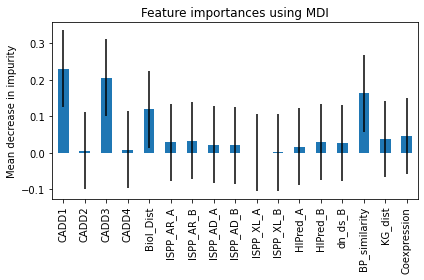

In [56]:
import matplotlib.pyplot as plt

feature_names = list(tdf.columns)[1:-2]
forest_importances = pd.Series(imp, index=feature_names)


fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Imblearn Logo


### LOGO CV 

In [20]:
def get_flatmetrics(flat_y, flat_pred):
    accs = []
    pres = []
    auc = []
    
    auc.append(roc_auc_score(flat_y, flat_pred))
    
    pres.append(precision_score(flat_y, flat_pred,zero_division= 0))
    
    accs.append(accuracy_score(flat_y, flat_pred))
        
        
    print("AUC: ", np.mean(auc), " | ", np.std(auc))
    print("accuracy: ", np.mean(accs), " | ", np.std(accs))
    print("precision: ", np.mean(pres), " | ", np.std(pres))
    print("classi report:" , classification_report(flat_pred, flat_y))
    tn, fp, fn, tp  = confusion_matrix(flat_y, flat_pred).ravel()
    print()
    print("tn fp fn tp")
    print(tn, fp, fn, tp)

In [21]:
fo = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0]

dfmn = get_cols(dfm, fo)        

X_train = array(dfmn)[:,1:-2].astype(float)
y_train = array(dfmn.y)


X_test = array(kgt1)[:,1:-2].astype(float)
y_test = array(kgt1.y)

In [ ]:
def train_logo(logo):

    rf_models = []
    testsets = []

    
    
    trainset = dfmn    
    trainset.reset_index(drop=True, inplace=True) 


    train = trainset[trainset.gp != logo]
    test = trainset[trainset.gp == logo]
    

    # for balanced logo:
    #to_rem = len(test)
    #df_1KGP = train[train.y ==0] 
    #idx = df_1KGP.sample(to_rem)
    #test = pd.concat([test, idx])
    #train = train.drop(idx.index, axis=0) 
    


    X = (array(train)[:,1:-2].astype(float))
    y = array(train.y)
    # train Random Forest
    clf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)


    clf.fit(X, y)

    X_test = (array(test)[:,1:-2].astype(float))
    y_test = array(test.y)

    predictions = clf.predict_proba(X_test)[:, 1]
    
    
    return y_test, predictions
    
    
    
    
    

p = Pool(30)   # change to cores available 
# for balanced logo:
#testmodels = list(tqdm.tqdm(p.imap_unordered(train_logo, di_gps), total=len(di_gps)))
predies = list(tqdm.tqdm(p.imap_unordered(train_logo, all_gps), total=len(all_gps)))
p.close()

In [27]:
# pre-computed full logo
logo_preds = open("Full_LogoPredies.pickle", 'rb')
predies = pickle.load(logo_preds)

In [28]:
y_true = []
y_prob = []

for p in range(len(predies)):
    y_true+=list(predies[p][0])
    y_prob+= list(predies[p][1])

In [29]:
# AUC
roc_auc_score(y_true,y_prob)

0.985821674487961

In [30]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
thresh = thresholds[np.argmax(tpr - fpr)]
print(thresh)

0.49


In [32]:
y_pred = [1 if e >= thresh else 0 for e in y_prob]

In [35]:
print(classification_report_imbalanced(y_true, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.95      0.94      0.97      0.94      0.89    151000
          1       0.03      0.94      0.95      0.07      0.94      0.89       302

avg / total       1.00      0.95      0.94      0.97      0.94      0.89    151302



In [37]:
get_flatmetrics(y_true, y_pred)

AUC:  0.9419205298013245  |  0.0
accuracy:  0.9467356677373729  |  0.0
precision:  0.03400216268172534  |  0.0
classi report:               precision    recall  f1-score   support

           0       0.95      1.00      0.97    142979
           1       0.94      0.03      0.07      8323

    accuracy                           0.95    151302
   macro avg       0.94      0.52      0.52    151302
weighted avg       0.95      0.95      0.92    151302


tn fp fn tp
142960 8040 19 283


### Independent Val

In [39]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100,
                                     random_state=1)

brf.fit(X_train, y_train) 


BalancedRandomForestClassifier(random_state=1)

In [40]:
y_pred = brf.predict_proba(X_test)[:, 1]

In [42]:
predicted = (y_pred >= thresh).astype('int')
print(classification_report_imbalanced(y_test, predicted))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.95      1.00      0.97      0.97      0.94     10000
          1       0.09      1.00      0.95      0.17      0.97      0.95        53

avg / total       1.00      0.95      1.00      0.97      0.97      0.94     10053



### treeinterpreter

In [47]:
# change X_test to only pos or only neg
rf_prediction, rf_bias, rf_contributions = ti.predict(brf, X_test)

In [48]:
df_feature_all = pd.DataFrame(rf_contributions[:,:,1], columns=list(dfmn.columns[1:-2]))


In [49]:
df_feature_long = pd.melt(df_feature_all,var_name='feature', value_name='contribution')

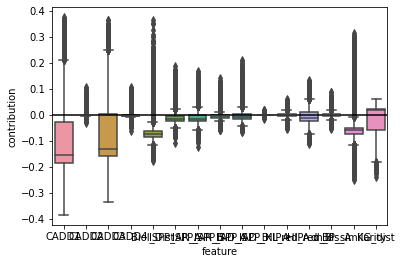

In [50]:
graph = sns.boxplot(x="feature", y="contribution", data=df_feature_long) #, order=df_feature_importance.index);
graph.axhline(0, c='black')
#plt.savefig('treeint_pos_contr.eps')

### time eval

In [55]:
start_time = time.time()
times = []
for _ in tqdm.tqdm(range(50)):
    start_time = time.time()
    y_pred = brf.predict_proba(X_test)[:, 1]
    predicted = (y_pred >= thresh).astype('int')
    times.append(time.time() - start_time)

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 16.93it/s]


In [56]:
print(np.mean(times))
print(np.std(times))

0.058775019645690915
0.005888875844411255


### number of estimators test

In [57]:

estimators = []
aucs = []

for i in tqdm.tqdm(range(1, 206, 5)):

    brf = BalancedRandomForestClassifier(n_estimators=i, random_state=1)
    brf.fit(X_train, y_train) 
    y_pred = brf.predict(X_test)
    estimators.append(i)    
    aucs.append(roc_auc_score(y_test, y_pred))               

100%|███████████████████████████████████████████| 41/41 [02:13<00:00,  3.25s/it]


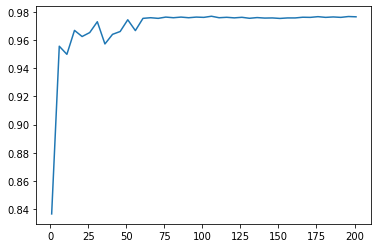

In [58]:
plt.plot(estimators, aucs)

### Trying RF with different negative sets for DTs

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier

estimators_i = []
aucs = []


dts = 500
max_d = 10
estimators = []
for i in range(dts):
    setn = str(i+1) 
    kgi = kg[kg.Combination_ID.str.match(r'(set_'+setn+'_.*)')==True]   
    tdf = pd.concat([kgi, di])
    tdf = tdf.fillna(imputevals)
    tdf = get_cols(tdf, fo)
    X_train = array(tdf)[:,1:-2].astype(float)
    y_train = array(tdf.y)
    dt = DecisionTreeClassifier(random_state= i, max_depth=max_d).fit(X_train, y_train)
    estimators.append(('dt' + str(i), dt))
probs=[]    
for _, dt in estimators:
    probs.append(dt.predict_proba(X_test)[:, 1])
    

In [111]:
y_pred = np.mean(np.array(probs), 0)

In [91]:
clf= RandomForestClassifier(n_estimators=500, max_depth=10, random_state=10)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=10)

In [ ]:
predicted = (y_pred >= threshold).astype('int')
print(roc_auc_score(y_test,y_pred))
get_metrics([(y_test,predicted)])
matthews_corrcoef(y_test,predicted)

In [ ]:
print(roc_auc_score(y_test,y_pred))
get_metrics([(y_test,predicted)])


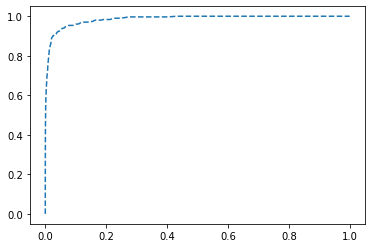

In [59]:
from matplotlib import pyplot
pyplot.plot(fpr, tpr, linestyle='--')